In [2]:
import sys

sys.path.insert(0, "/Users/jtlaune/Notes/notes/code_notebooks/")
sys.path.insert(0,"/Users/jtlaune/athena/vis/python/")
import athena_read
from mpl_styles import analytic
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import scipy as sp
import numpy as np
import os
import yt

accRunDir = "/Users/jtlaune/runs/JTrunII_Acc/"
noAccRunDir = "/Users/jtlaune/runs/JTrunII_noAcc/"
%matplotlib inline

In [3]:
def get_bbox(x1min,x1max,x2min,x2max,data_dict,filename):
    strobe = 1
    x1min_ind = np.where(data_dict["x1v"]>x1min)[0][0]
    x1max_ind = np.where(data_dict["x1v"]>x1max)[0][0]
    x2min_ind = np.where(data_dict["x2v"]>x2min)[0][0]
    x2max_ind = np.where(data_dict["x2v"]>x2max)[0][0]

    rho = data_dict["dens"][0,:,:]
    vr = data_dict["mom1"][0,::1,::1]/data_dict["dens"][0,::1,::1]
    vth = data_dict["mom2"][0,::1,::1]/data_dict["dens"][0,::1,::1]

    coordsr, coordsth = data_dict["x1v"], data_dict["x2v"]
    #coordsx = coordsr*np.cos(coordsth)
    #coordsy = coordsr*np.sin(coordsth)

    rc = coordsr[x1min_ind:x1max_ind:strobe]
    thc = coordsth[x2min_ind:x2max_ind:strobe]
    rhoc = rho[x2min_ind:x2max_ind:strobe,x1min_ind:x1max_ind:strobe]
    vrc = vr[x2min_ind:x2max_ind:strobe,x1min_ind:x1max_ind:strobe]
    vthc = vth[x2min_ind:x2max_ind:strobe,x1min_ind:x1max_ind:strobe]

    np.savez(filename,rho=rhoc,vr=vrc,vth=vthc,r=rc,th=thc)

def get_cartInterpVels(data,nx,ny):


    xg = np.linspace(data["r"][0],data["r"][-1]*np.cos(data["th"][0]),nx)
    yg = np.linspace(data["r"][0]*data["th"][0],data["r"][0]*data["th"][-1],ny)
    xg, yg = np.meshgrid(xg,yg)
    xg = xg.flatten()
    yg = yg.flatten()

    rc, thc = np.meshgrid(data["r"],data["th"])
    rc = rc.flatten()
    thc = thc.flatten()
    xc = (rc*np.cos(thc)).flatten()
    yc = (rc*np.sin(thc)).flatten()
    vrc = data["vr"].flatten()
    vthc = data["vth"].flatten()

    xdotc = vrc*np.cos(thc) - rc*np.sin(thc)*vthc
    ydotc = vrc*np.sin(thc) + rc*np.cos(thc)*vthc

    xdotg = sp.interpolate.griddata((xc,yc), xdotc, (xg,yg))
    ydotg = sp.interpolate.griddata((xc,yc), ydotc, (xg,yg))
    return(xg.reshape(nx,ny),yg.reshape(nx,ny),xdotg.reshape(nx,ny),ydotg.reshape(nx,ny)) 


In [11]:
iout = 260
accFname = accRunDir+f"{iout:05}_1.1rH.npz"
noAccFname = noAccRunDir+f"{iout:05}_1.1rH.npz" 

In [12]:
dataAcc = athena_read.athdf(accRunDir+f"ppd_cyl.out1.{iout:05}.athdf")
dataNoAcc = athena_read.athdf(noAccRunDir+f"ppd_cyl.out1.{iout:05}.athdf")
get_bbox(1-1.1*0.032,1+1.1*0.032,-0.032*1.1,0.032*1.1,dataAcc,accFname)
get_bbox(1-1.1*0.032,1+1.1*0.032,-0.032*1.1,0.032*1.1,dataNoAcc,noAccFname)

In [13]:
dataAcc = np.load(accFname)
dataNoAcc = np.load(noAccFname)

In [20]:
interpx,interpy,interpxdot,interpydot = get_cartInterpVels(dataAcc, 500, 500)

In [23]:
mpl.rcParams["text.usetex"] = True

/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_35083/1497868685.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = ax.pcolormesh(RR*np.cos(TT),RR*np.sin(TT),dataAcc["rho"]/Sig0,norm=colors.LogNorm(vmin=1e-1,vmax=1e1),cmap="inferno")


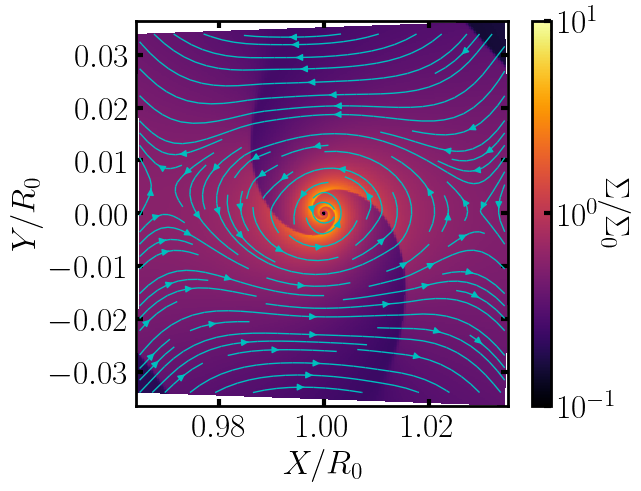

In [26]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
    Sig0 = 0.001
    RR,TT = np.meshgrid(dataAcc["r"],dataAcc["th"])
    cs = ax.pcolormesh(RR*np.cos(TT),RR*np.sin(TT),dataAcc["rho"]/Sig0,norm=colors.LogNorm(vmin=1e-1,vmax=1e1),cmap="inferno")
    ax.streamplot(interpx,interpy,interpxdot,interpydot,linewidth=1,color="c")
    cb = plt.colorbar(cs)
    cb.ax.set_ylabel(r"$\Sigma/\Sigma_0$",rotation=270,labelpad=10)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.set_xlabel(r"$X/R_0$")
    ax.set_ylabel(r"$Y/R_0$")
    fig.savefig("/Users/jtlaune/Desktop/Accreting1_1RH.png",dpi=300,bbox_inches="tight")

In [28]:
interpx,interpy,interpxdot,interpydot = get_cartInterpVels(dataNoAcc, 500, 500)

/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_35083/385680116.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = ax.pcolormesh(RR*np.cos(TT),RR*np.sin(TT),dataNoAcc["rho"]/Sig0,norm=colors.LogNorm(vmin=1e-1,vmax=1e1),cmap="inferno")


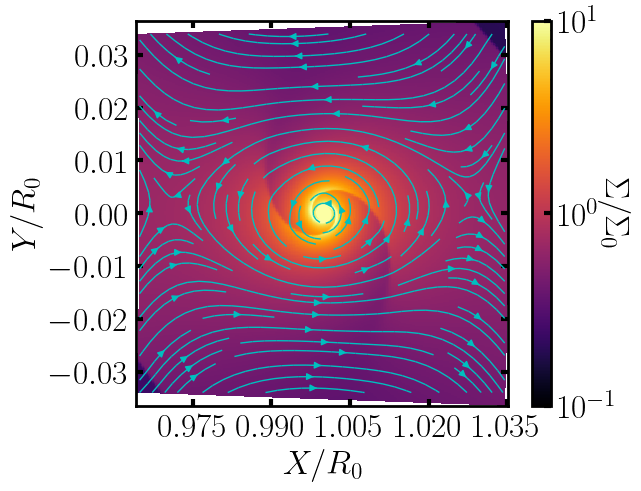

In [29]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
    Sig0 = 0.001
    RR,TT = np.meshgrid(dataNoAcc["r"],dataNoAcc["th"])
    cs = ax.pcolormesh(RR*np.cos(TT),RR*np.sin(TT),dataNoAcc["rho"]/Sig0,norm=colors.LogNorm(vmin=1e-1,vmax=1e1),cmap="inferno")
    ax.streamplot(interpx,interpy,interpxdot,interpydot,linewidth=1,color="c")
    cb = plt.colorbar(cs)
    cb.ax.set_ylabel(r"$\Sigma/\Sigma_0$",rotation=270,labelpad=10)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.set_xlabel(r"$X/R_0$")
    ax.set_ylabel(r"$Y/R_0$")
    fig.savefig("/Users/jtlaune/Desktop/NonAccreting1_1RH.png",dpi=300,bbox_inches="tight")

In [14]:
iout = 260
ds = yt.load(accRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")

yt : [WARNING  ] 2023-05-04 16:23:20,713 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-04 16:23:20,713 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-04 16:23:20,714 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-04 16:23:20,714 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-04 16:23:20,732 Parameters: current_time              = 1633.6215
yt : [INFO     ] 2023-05-04 16:23:20,733 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-04 16:23:20,733 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-04 16:23:20,733 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-04 16:23:20,733 Parameters: cosmological_simulation   = 0


yt : [WARNING  ] 2023-05-04 16:21:50,801 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-04 16:21:50,802 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-04 16:21:50,802 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-04 16:21:50,803 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2023-05-04 16:21:50,823 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-05-04 16:21:50,824 Parameters: domain_dimensions         = [ 256 1536    1]
yt : [INFO     ] 2023-05-04 16:21:50,824 Parameters: domain_left_edge          = [ 0.40000001 -3.14159274 -0.5       ]
yt : [INFO     ] 2023-05-04 16:21:50,824 Parameters: domain_right_edge         = [1.60000002 3.14159274 0.5       ]
yt : [INFO     ] 2023-05-04 16:21:50,824 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2023-05-04 16:21:57,336 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2023-05-04 16:21:57,337 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2023-05-04 16:21:57,337 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2023-05-04 16:21:57,337 Assuming 1.0 = 1.0 K
y

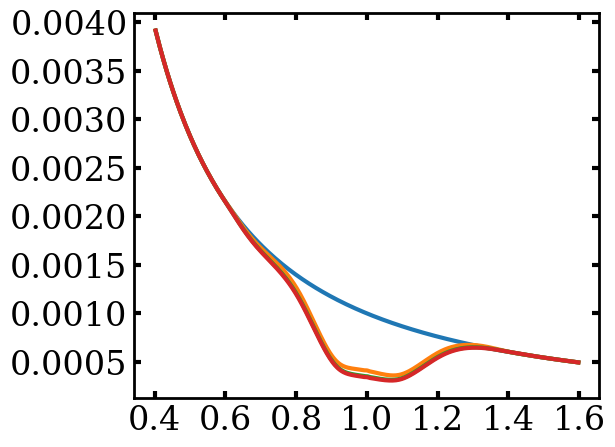

In [11]:
with mpl.rc_context(analytic):
    fig, ax = plt.subplots()
    ds = yt.load(accRunDir + f"/ppd_cyl.out1.{iout:05}.athdf")
    dd = ds.all_data()
    dd["athena_pp","dens"].shape
    rg = np.linspace(0.4,1.6,1000)
    pg = np.linspace(-np.pi,np.pi,6000)
    rr, pp = np.meshgrid(rg,pg)
    densg = sp.interpolate.griddata(dd.fcoords[:,:2],dd["athena_pp","dens"],(rr,pp),method="linear")
    densg = np.nan_to_num(densg,0)
    ax.plot(rg[2:-2],np.mean(densg,axis=0)[2:-2],label=f"T={iout} orbits")

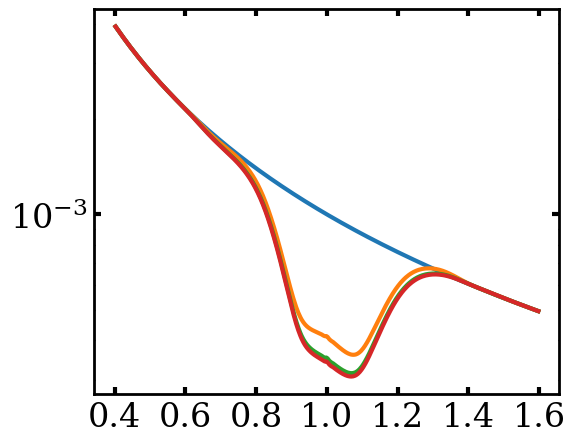

In [13]:
ax.set_yscale("log")
fig